In [2]:
import torch
from torch.nn import functional as F
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.core.lightning import LightningModule
from torch.optim import Adam
import torch
import torch.nn as nn
import time
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from typing import Any, Callable, List, Optional, Union
import numpy as np
from sklearn.model_selection import train_test_split
import argparse
import tqdm
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import os
from torchvision import datasets, transforms
from pytorch_lightning import Trainer


class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, dropout=None, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        self.dropout = dropout

    def prepare_data(self):
        # download only
        MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor())
        MNIST(os.getcwd(), train=False, download=True, transform=transforms.ToTensor())

    def setup(self, targets2keep=[3,8], stage: Optional[str] = None):
        # transform
        transform = transforms.Compose([transforms.ToTensor()])
        mnist_train = MNIST(os.getcwd(), train=True, download=False, transform=transform)
        mnist_test = MNIST(os.getcwd(), train=False, download=False, transform=transform)
        
        if self.dropout is not None:
            j, k = self.dropout
            mnist_train.data[:, j, k] = 0
            mnist_test.data[:, j, k] = 0

        # keep the relevant classes
        ix_train = np.array([])
        ix_test = np.array([])
        for t in targets2keep:
            ix_train = np.append(ix_train, np.where(mnist_train.targets==t)[0])
            ix_test = np.append(ix_test, np.where(mnist_test.targets==t)[0])
        
        np.random.shuffle(ix_train)
        np.random.shuffle(ix_test)

        mnist_train.data = mnist_train.data[ix_train]
        mnist_test.data = mnist_test.data[ix_test]

        y_train = mnist_train.targets[ix_train]
        y_test = mnist_test.targets[ix_test]

        mnist_train.targets = torch.tensor([1 if y==targets2keep[1] else 0 for y in y_train ], 
                                           dtype=torch.float32).view(-1,1)
        mnist_test.targets = torch.tensor([1 if y==targets2keep[1] else 0 for y in y_test ], 
                                          dtype=torch.float32).view(-1,1)
        
        # train/val split
        n = mnist_train.data.shape[0]
        n_train = int(np.floor(n*.8))
        n_val = int(n - n_train)
        mnist_train, mnist_val = random_split(mnist_train, [n_train, n_val])

        # assign to use in dataloaders
        self.train_dataset = mnist_train
        self.val_dataset = mnist_val
        self.test_dataset = mnist_test

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)
    
    
class LiteMNIST(LightningModule):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(28 * 28, 128)
        self.layer_2 = nn.Linear(128, 1)

    def forward(self, x):
        batch_size = x.size()[0]
        x = torch.tensor(x.view(batch_size, -1), dtype=torch.float32)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.sigmoid(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = torch.tensor(y, dtype=torch.float32).view(-1,1)
        logits = self(x)
        loss = nn.BCELoss()(logits, y)
        return loss
    
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y = torch.tensor(y, dtype=torch.float32).view(-1,1)
        probs = self(x)
        loss = nn.BCELoss()(probs, y)
        y_hat = torch.round(probs)
        accuracy = torch.sum(y == y_hat).item() / (len(y) * 1.0)
        output = dict({
            'test_loss': loss,
            'test_acc': torch.tensor(accuracy),
        })
        return output
    

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)

In [3]:

dm = MNISTDataModule()
model = LiteMNIST()
trainer = Trainer(max_epochs=10)
trainer.fit(model, dm)

X_test = dm.test_dataset.data
y_test = dm.test_dataset.targets
y_hat = torch.round(model(X_test))
acc0 = torch.sum(y_test == y_hat).item() / len(y_test) * 1.0

acc0

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 129   
-----------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.402     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

0.9889112903225806

In [337]:
results = []
for j in range(28):
    for k in range(28):
        if np.random.uniform() > .95:
            dmj = MNISTDataModule(dropout = [j,k])
            model = LitMNIST()
            trainer = Trainer(max_epochs=10)
            trainer.fit(model, dmj)
            X_test = dmj.test_dataset.data
            y_test = dmj.test_dataset.targets
            accj = torch.sum(y_test == model(X_test)).item() / len(y_test) * 1.0
            results.append([j, k, accj])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 257   
-----------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [338]:
df = pd.DataFrame(results, columns = ['i', 'j', 'accj'])
df['acc0'] = acc0
df['vi'] = df.acc0 - df.accj
df

,i,j,accj,acc0,vi
0,0,18,0.989919,0.990423,0.000504
1,1,17,0.991935,0.990423,-0.001512
2,1,20,0.992944,0.990423,-0.002520
3,1,21,0.992944,0.990423,-0.002520
4,1,22,0.991431,0.990423,-0.001008
5,2,0,0.987903,0.990423,0.002520
6,4,6,0.990927,0.990423,-0.000504
7,5,12,0.992944,0.990423,-0.002520
8,7,21,0.993952,0.990423,-0.003528
9,8,3,0.991935,0.990423,-0.001512


<AxesSubplot:xlabel='i', ylabel='j'>

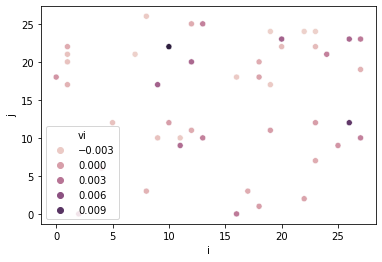

In [339]:
import seaborn as sns
sns.scatterplot(x='i', y='j', hue='vi', data=df)

In [11]:
from sklearn.model_selection import KFold
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils import *
from utils_concise import *
from classification_utils import *
from data_generating_funcs import *
import tqdm 

kf = KFold(n_splits=5, shuffle=True)
errors = []

In [13]:
# extract train/test from data_module
dmj = MNISTDataModule(dropout = [11,13])
dmj.setup()

Xj_train = dmj.train_dataset.dataset.data
y_train = dmj.train_dataset.dataset.targets

Xj_test = dmj.test_dataset.data
y_test = dmj.test_dataset.targets
y_test_np = y_test.detach().numpy()

kf = KFold(n_splits=5, shuffle=True)
for train, test in kf.split(Xj_train):
    break
    
errors = []
grads, flat_params, shape_info = extract_grad(Xj_train, model) # taking forever to extract gradients
# print(grads.shape)

In [36]:
lazy_pred_train, lazy_pred_test = lazy_predict_bin(grads[train], flat_params, model, shape_info,
                                                                   Xj_train[train], y_train[train],
                                                                   Xj_train[test], 10)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (268380x28 and 784x128)

In [23]:
dr_pred_train = model(Xj_train[train])

In [28]:
(y_train[train] - dr_pred_train).mean()

tensor(0.0054, grad_fn=<MeanBackward0>)

In [31]:
grads.shape

(11982, 133761)

In [32]:
lazy = Ridge(alpha=10).fit(grads[train], y_train[train] - dr_pred_train.detach().numpy())

In [39]:
delta = lazy.coef_
lazy_retrain_params = torch.FloatTensor(delta) + flat_params
lazy_retrain_Tlist = recover_tensors(lazy_retrain_params.reshape(-1), shape_info)
lazy_retrain_nn = BinClass()

In [21]:
    dr_pred_train = full_nn(X_train)
    lazy = Ridge(alpha=lam).fit(grads, y_train - dr_pred_train.detach().numpy())
    delta = lazy.coef_
    lazy_retrain_params = torch.FloatTensor(delta) + flat_params
    lazy_retrain_Tlist = recover_tensors(lazy_retrain_params.reshape(-1), shape_info)
    lazy_retrain_nn = BinClass()
    # hidden_layers probably doesn't need to be an argument here - get it from the structure
    for k, param in enumerate(lazy_retrain_nn.parameters()):
        param.data = lazy_retrain_Tlist[k]
    lazy_pred_train = lazy_retrain_nn(X_train)
    lazy_pred_test = lazy_retrain_nn(X_test)

torch.Size([9585, 28, 28])

In [ ]:
dr_pred_train = model(Xj_train[train])
grads_train = grads[train]
lazy_pred_train, lazy_pred_test = lazy_predict_bin(grads_train, flat_params, model, shape_info,
                                                   Xj_train[train], y_train[train],
                                                   Xj_train[test], lam)

In [182]:
# extract train/test from data_module
Xj_train = dmj.train_dataset.dataset.data
y_train = dmj.train_dataset.dataset.targets

Xj_test = dmj.test_dataset.data
y_test = dmj.test_dataset.targets
y_test_np = y_test.detach().numpy()

kf = KFold(n_splits=5, shuffle=True)
errors = []
grads, flat_params, shape_info = extract_grad(Xj_train, model)
# print(grads.shape)

for lam in np.logspace(-1,2,20):
    for train, test in kf.split(Xj_train):
        dr_pred_train = model(Xj_train[train])
        grads_train = grads[train]
        lazy_pred_train, lazy_pred_test = lazy_predict_bin(grads_train, flat_params, model, shape_info,
                                                           Xj_train[train], y_train[train],
                                                           Xj_train[test], lam)

0.984375

In [175]:
trainer.te

2048

In [197]:
b[0][0][0].shape

torch.Size([28, 28])

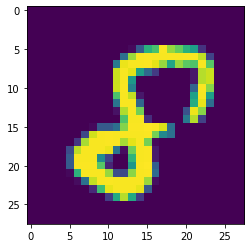

In [198]:
from matplotlib import pyplot as plt
plt.imshow(b[0][0][0])

In [208]:
model(b[0][:1, :, :])

tensor([[1.]], grad_fn=<SigmoidBackward0>)

In [212]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = MNIST(os.getcwd(), train=True, download=False, transform=transform)

In [214]:
mnist_train.data.shape

torch.Size([60000, 28, 28])

In [223]:
mnist_train.data[:, 10, 10] = 0

In [224]:
mnist_train.data[:, 10, 10]

tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)

In [209]:
for j in range(28):
    for k in range(28):
        

784

In [157]:
torch.tensor(b[1], dtype=torch.float32)

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1.,
        1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 0., 1., 0., 0., 0., 0., 0., 1.])

In [160]:
nn.BCELoss()(torch.tensor(model(b[0]), dtype=torch.float32),
             torch.tensor(b[1], dtype=torch.float32).view(-1,1))

tensor(0.6920)

In [162]:
nn.BCELoss()(model(b[0]), torch.tensor(b[1], dtype=torch.float32).view(-1,1))

tensor(0.6920, grad_fn=<BinaryCrossEntropyBackward0>)